**Program melatih model menggunakan VGG19**

In [1]:
# Import library yang dibutuhkan
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import splitfolders

In [2]:
# Path direktori data latihan dan validasi
input_dir = 'C:/Users/RAIHAN FAIZ/Documents/Skripsi/Penelitian/Dataset/CK+48/dataset/'
output_dir = 'C:/Users/RAIHAN FAIZ/Documents/Skripsi/Penelitian/Percobaan/Percobaan C_VGG19/CK+48/split/'
split_ratio = (0.8, 0.1, 0.1)  # Rasio pembagian train, val, test

# Split folder
splitfolders.ratio(input_dir, output=output_dir, seed=42, ratio=split_ratio)

Copying files: 981 files [00:02, 461.60 files/s]


In [3]:
# Path direktori data train, validasi, dan test
train_dir = output_dir + 'train'
val_dir = output_dir + 'val'
test_dir = output_dir + 'test'

In [4]:
# Parameter model dan pelatihan
input_shape = (48, 48, 3)
num_classes = 7
batch_size = 64
epochs = 100

In [5]:
# Membuat generator data latihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True  # Tambahkan pergeseran vertikal
)

# Membuat generator data validasi dan test tanpa augmentasi
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Muat dan augmentasi data latihan
train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='rgb',  # Ubah color_mode menjadi 'rgb'
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

# Muat data validasi
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    color_mode='rgb',  # Ubah color_mode menjadi 'rgb'
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

# Muat data test
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    color_mode='rgb',  # Ubah color_mode menjadi 'rgb'
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 783 images belonging to 7 classes.
Found 94 images belonging to 7 classes.
Found 104 images belonging to 7 classes.


In [7]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model

# Membangun model VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [8]:
# Kompilasi model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Callback untuk menghentikan pelatihan jika akurasi mencapai target
class MyCallback(keras.callbacks.Callback):
    def __init__(self, target_accuracy):
        super(MyCallback, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy >= self.target_accuracy:
            print(f"\nValidation accuracy reached {self.target_accuracy}. Training stopped.")
            self.model.stop_training = True

# Set target accuracy yang diinginkan
target_accuracy = 0.9
callbacks = [MyCallback(target_accuracy)]

In [10]:
# Latih model menggunakan generator data dan callback
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks
)

Epoch 1/100
12/12 [==============================] - 46s 4s/step - loss: 2.0220 - accuracy: 0.1933 - val_loss: 1.8212 - val_accuracy: 0.2656
Epoch 2/100
12/12 [==============================] - 38s 3s/step - loss: 1.7705 - accuracy: 0.3074 - val_loss: 1.8210 - val_accuracy: 0.2031
Epoch 3/100
12/12 [==============================] - 39s 3s/step - loss: 1.6817 - accuracy: 0.3700 - val_loss: 1.4971 - val_accuracy: 0.4219
Epoch 4/100
12/12 [==============================] - 42s 4s/step - loss: 1.3768 - accuracy: 0.5104 - val_loss: 1.1755 - val_accuracy: 0.5156
Epoch 5/100
12/12 [==============================] - 36s 3s/step - loss: 1.3088 - accuracy: 0.5021 - val_loss: 2.0242 - val_accuracy: 0.4219
Epoch 6/100
12/12 [==============================] - 35s 3s/step - loss: 1.2354 - accuracy: 0.5466 - val_loss: 1.0663 - val_accuracy: 0.6250
Epoch 7/100
12/12 [==============================] - 35s 3s/step - loss: 0.9699 - accuracy: 0.6342 - val_loss: 1.2644 - val_accuracy: 0.5938
Epoch 8/100
1

In [11]:
# Simpan model dengan metadata label
model.save('emotion_model_vgg19.h5')

**Menguji Model dengan Data Uji yang disiapkan**

In [12]:
import random
import os

test_samples_dir = 'C:/Users/RAIHAN FAIZ/Documents/Skripsi/Penelitian/Dataset/CK+48/split/test'
class_names = sorted(os.listdir(test_samples_dir))

# Memilih 5 sampel acak dari setiap kelas emosi
random_samples = {}
for class_name in class_names:
    class_dir = os.path.join(test_samples_dir, class_name)
    sample_files = os.listdir(class_dir)
    random_samples[class_name] = random.sample(sample_files, 5)

In [13]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Fungsi untuk menguji model pada satu sampel gambar
def predict_emotion(model, image_path):
    image = load_img(image_path, color_mode='rgb', target_size=(48, 48))
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    result = model.predict(image_array)
    return result[0]

# Proses pengujian
for class_name, samples in random_samples.items():
    print(f"\nEmosi: {class_name}")
    for sample_file in samples:
        sample_path = os.path.join(test_samples_dir, class_name, sample_file)
        result = predict_emotion(model, sample_path)
        predicted_class = class_names[np.argmax(result)]
        print(f"Gambar: {sample_file} => Prediksi: {predicted_class}, Skor: {result.max():.4f}")



Emosi: anger
1/1 [==============================] - 0s 312ms/step
Gambar: S506_001_00000039.png => Prediksi: sad, Skor: 0.5152
1/1 [==============================] - 0s 47ms/step
Gambar: S034_003_00000026.png => Prediksi: anger, Skor: 0.9709
1/1 [==============================] - 0s 53ms/step
Gambar: S075_008_00000010.png => Prediksi: anger, Skor: 0.9026
1/1 [==============================] - 0s 42ms/step
Gambar: S011_004_00000019.png => Prediksi: anger, Skor: 0.9480
1/1 [==============================] - 0s 47ms/step
Gambar: S117_006_00000009.png => Prediksi: anger, Skor: 0.9788

Emosi: disgust
1/1 [==============================] - 0s 47ms/step
Gambar: S087_004_00000012.png => Prediksi: disgust, Skor: 0.9285
1/1 [==============================] - 0s 34ms/step
Gambar: S108_006_00000020.png => Prediksi: disgust, Skor: 0.9996
1/1 [==============================] - 0s 34ms/step
Gambar: S067_006_00000011.png => Prediksi: disgust, Skor: 0.9984
1/1 [==============================] - 0s 26m

**Plot Akurasi dan Loss, Classification Report, dan Confusion Matrix**

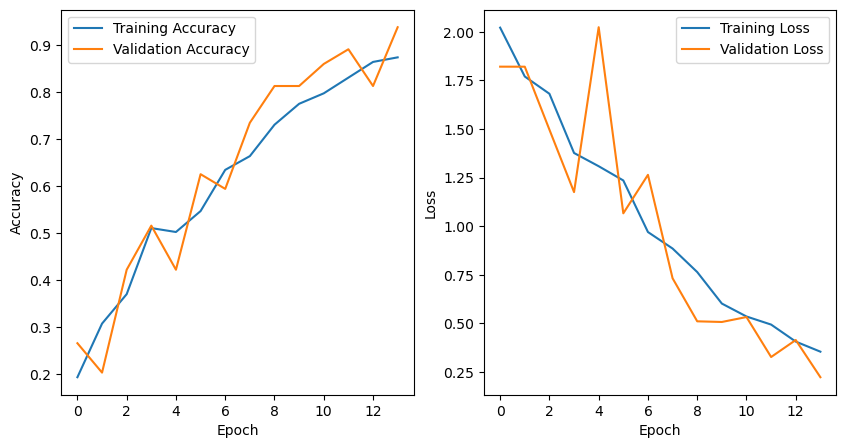

In [14]:
# Plot akurasi dan loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Evaluasi model pada data test
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

2/2 [==============================] - 1s 331ms/step - loss: 0.1934 - accuracy: 0.9423
Test Loss: 0.19341212511062622
Test Accuracy: 0.942307710647583


In [16]:
# Prediksi menggunakan model
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

2/2 [==============================] - 1s 266ms/step


In [17]:
# Classification report
target_names = list(test_generator.class_indices.keys())
classification_rep = classification_report(y_true, y_pred_classes, target_names=target_names)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

       anger       0.82      1.00      0.90        14
     disgust       1.00      1.00      1.00        19
        fear       1.00      0.62      0.77         8
       happy       1.00      1.00      1.00        22
     nuetral       1.00      0.67      0.80         6
         sad       0.73      0.89      0.80         9
    surprise       1.00      1.00      1.00        26

    accuracy                           0.94       104
   macro avg       0.94      0.88      0.90       104
weighted avg       0.95      0.94      0.94       104



In [18]:
# Confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(confusion_mtx)

Confusion Matrix:
[[14  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0]
 [ 0  0  5  0  0  3  0]
 [ 0  0  0 22  0  0  0]
 [ 2  0  0  0  4  0  0]
 [ 1  0  0  0  0  8  0]
 [ 0  0  0  0  0  0 26]]


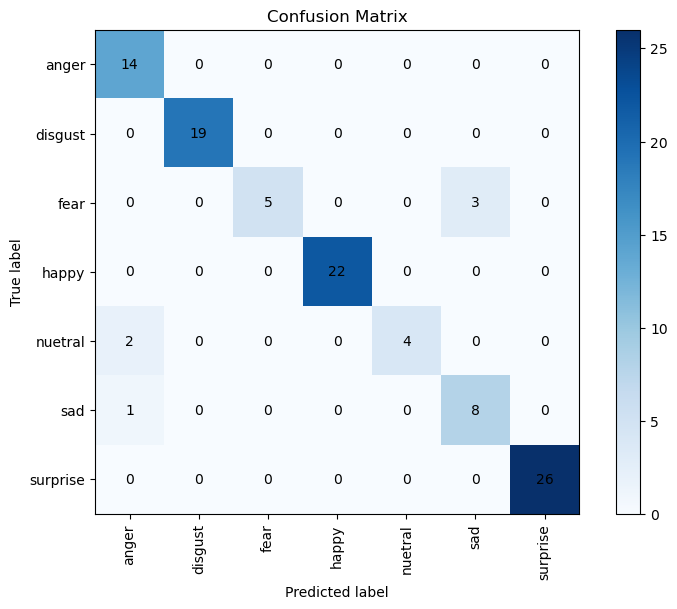

In [19]:
# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Menambahkan angka pada matriks
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        plt.text(j, i, str(confusion_mtx[i, j]), color='black', horizontalalignment='center', verticalalignment='center')

plt.show()